In [1]:
import pandas as pd
import prince
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from datetime import datetime

import logging 

from scipy.signal import argrelextrema

plt.rcParams["figure.figsize"] = (20,3)


data = pd.read_csv(r"../data/data.csv")

In [2]:
class Node:
    
    def __init__(self,points):
        self.points = points
        self.mean = np.mean(points)
        self.var = np.var(points)
        self.size = len(points)
        
    def __repr__(self):
        return str(self.mean)

In [3]:
class Categoricer:
    
    def __init__(self,ward_linkeage="single",ward_affinity="euclidean",ward_children_limit=20,show_graph_solution=False):
        self.__ward_linkeage = ward_linkeage
        self.__ward_affinity = ward_affinity
        self.__ward_children_limit = ward_children_limit
        self.__show_graph_solution = show_graph_solution
        self.__scaler = StandardScaler()
        
    def generate_cagegories(self,data):
        data_copy = data.copy(deep=True)
        for column in data.columns:
            if data[column].dtype in ["int64","float64","complex","timedelta64","datetime64"]:
                print(f"[Categoricer {datetime.now()}] Column: {column}, is Numeric")
                self.__transform_numeric_column(data_copy,column)
            else:
                print(f"[Categoricer {datetime.now()}] Column: {column}, is Categorical")
                self.__transform_categorical_column(data_copy,column)
        return data_copy
            
    
    def __transform_numeric_column(self,data,column):
        X = self.__scaler.fit_transform( [[x] for x in data[column].values] )
        K = self.__find_optimal_clusters_number(X)
        print(f"[Categoricer {datetime.now()}] Column: {column}, optimal K: {K}")
        model = AgglomerativeClustering(
            n_clusters=K,
            metric=self.__ward_affinity,
            linkage=self.__ward_linkeage,
            compute_full_tree=True)
        model.fit(X)
        if(self.__show_graph_solution):
            self.__draw_solution(column,X,model.labels_)
        print(f"[Categoricer {datetime.now()}] Column: {column}, creating categories labels")
        for i in range(len(data)):
            category = chr(model.labels_[i]+65)
            data.loc[i,column] = category 
            
            
    def __transform_categorical_column(self,data,column):
        print(f"[Categoricer {datetime.now()}] Column: {column}, creating categories labels")
        for i,value in enumerate(data[column].unique()):
            category = chr(i+65)
            data.loc[data[column]==value, column] = category
            
        
    def __find_optimal_clusters_number(self,X):
        # generate clusters childs for full tree
        model = AgglomerativeClustering(
            n_clusters=1,
            metric=self.__ward_affinity,
            linkage=self.__ward_linkeage,
            compute_full_tree=True)
        model.fit(X)
        # calculate the disstortions with intravariance
        clusters = {}
        intra_variances = []
        # init individual clusters
        for i in range(len(X)):
            clusters[i] = Node([X[i][0]])       
        # Merge clusters for full tree
        count = len(X)
        for merge_step in model.children_:
            nodeA, nodeB = clusters.pop(merge_step[0]) , clusters.pop(merge_step[1])
            clusters[count] = Node( nodeA.points + nodeB.points )
            intra_variances.append( np.sum( [ clusters[key].var*clusters[key].size for key in clusters ] ) / len(X) )
            count += 1
        intra_variances.reverse()
        K = self.__find_elbow_solution(intra_variances[:self.__ward_children_limit])
        return K
            
    def __find_elbow_solution(self,values):
        # Compute distances from points to the line connecting the first and last points
        x1, y1 = 1, values[0]
        x2, y2 = len(values), values[-1]
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
        distances = [np.abs(m * i - j + b) / np.sqrt(m ** 2 + 1) for i, j in enumerate(values, 1)] 
        # Find optimal number of clusters using elbow method
        max_distance_index = np.argmax(distances)
        return max_distance_index + 1
    
    def __draw_solution(self,column,data_list,labels):
        # Plot input data
        plt.title(column)
        plt.scatter(data_list, np.zeros(len(data_list)))
        plt.show()
        # Plot solution
        for label in np.unique(labels):
            data_label_values = data_list[labels == label]
            plt.scatter(data_label_values, np.zeros(len(data_label_values)))
        plt.show()

[Categoricer 2023-05-27 18:00:09.972817] Column: ingresos, is Numeric
[Categoricer 2023-05-27 18:00:14.628467] Column: ingresos, optimal K: 8


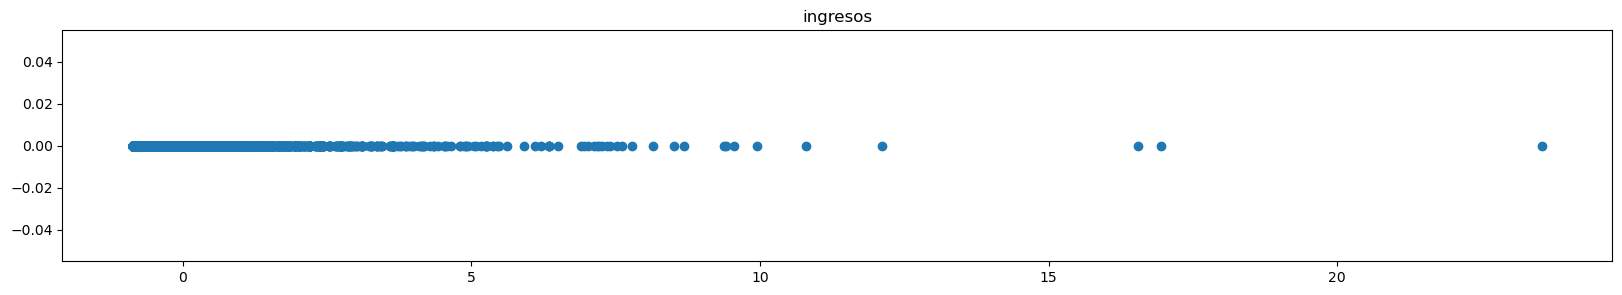

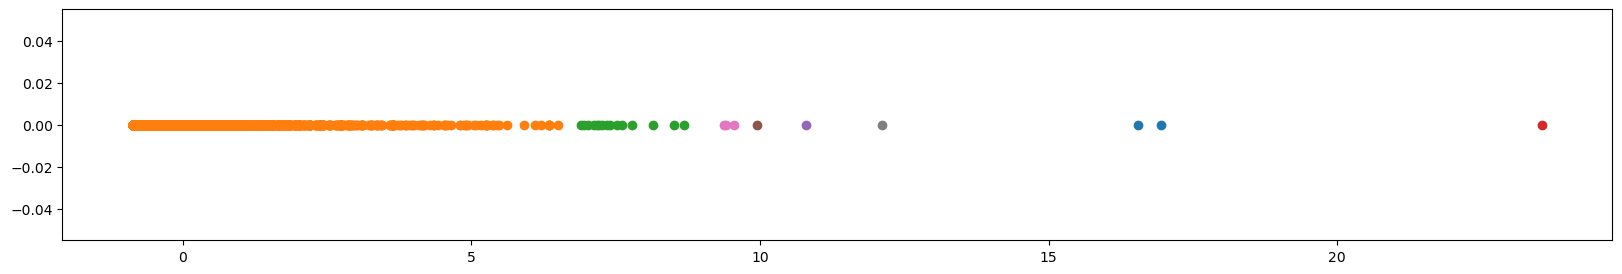

[Categoricer 2023-05-27 18:00:15.102037] Column: ingresos, creating categories labels
[Categoricer 2023-05-27 18:00:15.309211] Column: egresos, is Numeric
[Categoricer 2023-05-27 18:00:19.815420] Column: egresos, optimal K: 4


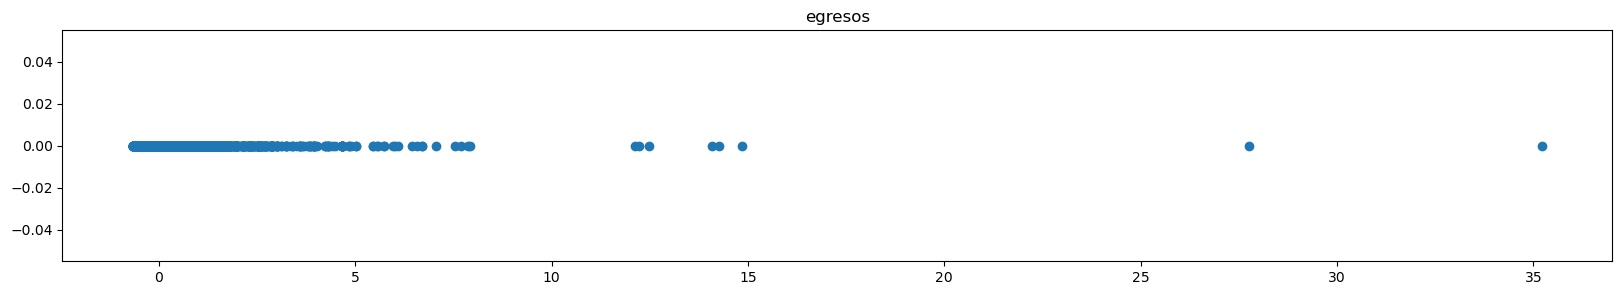

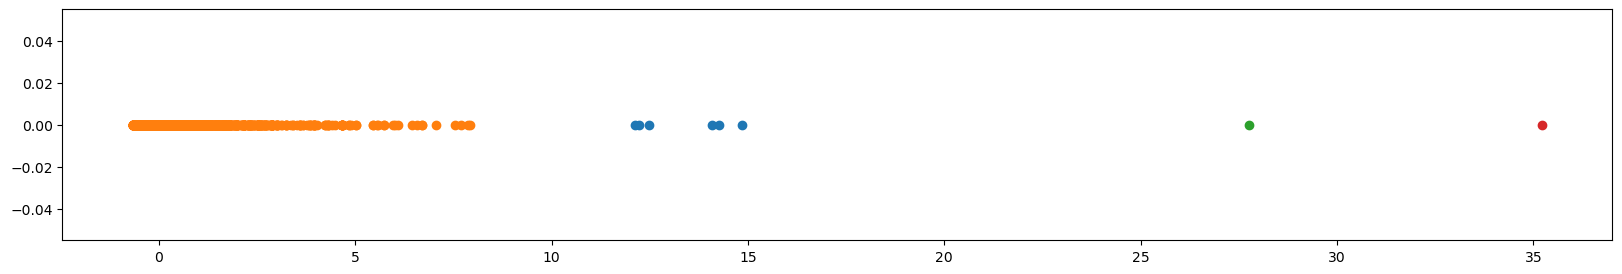

[Categoricer 2023-05-27 18:00:20.251582] Column: egresos, creating categories labels
[Categoricer 2023-05-27 18:00:20.455053] Column: activos, is Numeric
[Categoricer 2023-05-27 18:00:25.114500] Column: activos, optimal K: 10


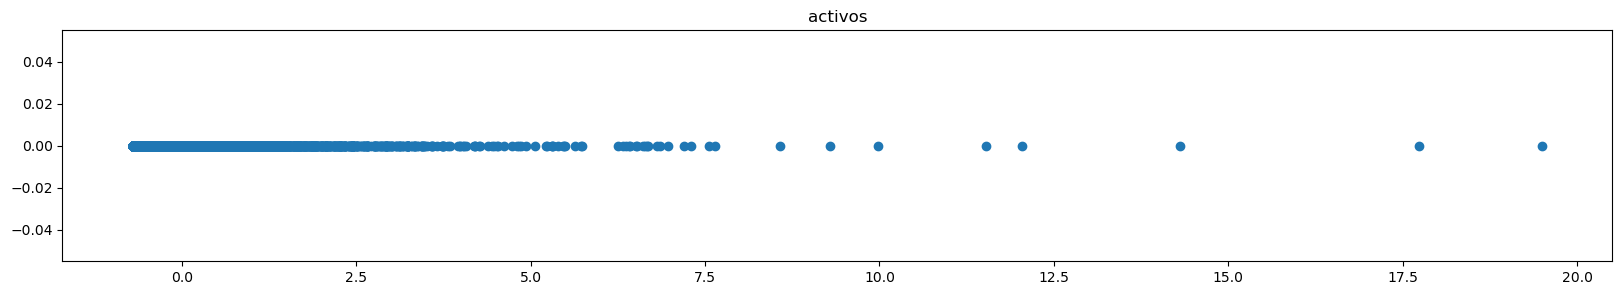

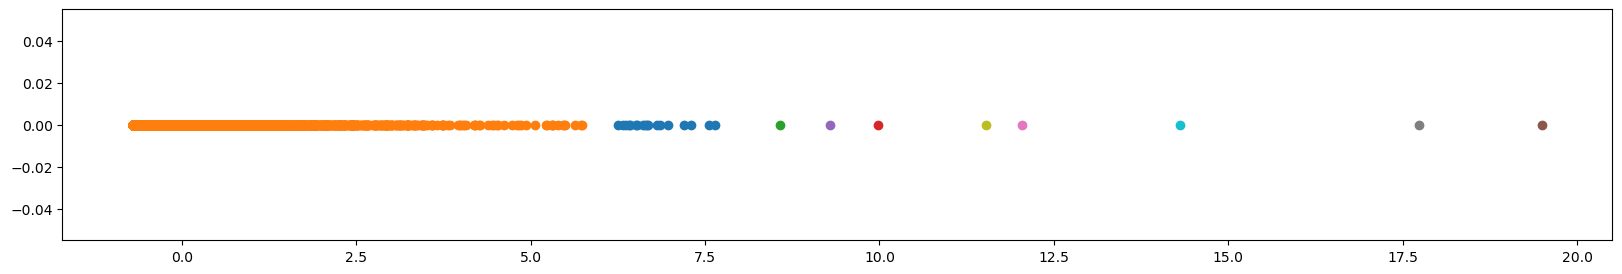

[Categoricer 2023-05-27 18:00:25.594817] Column: activos, creating categories labels
[Categoricer 2023-05-27 18:00:25.795745] Column: pasivos, is Numeric
[Categoricer 2023-05-27 18:00:30.479656] Column: pasivos, optimal K: 5


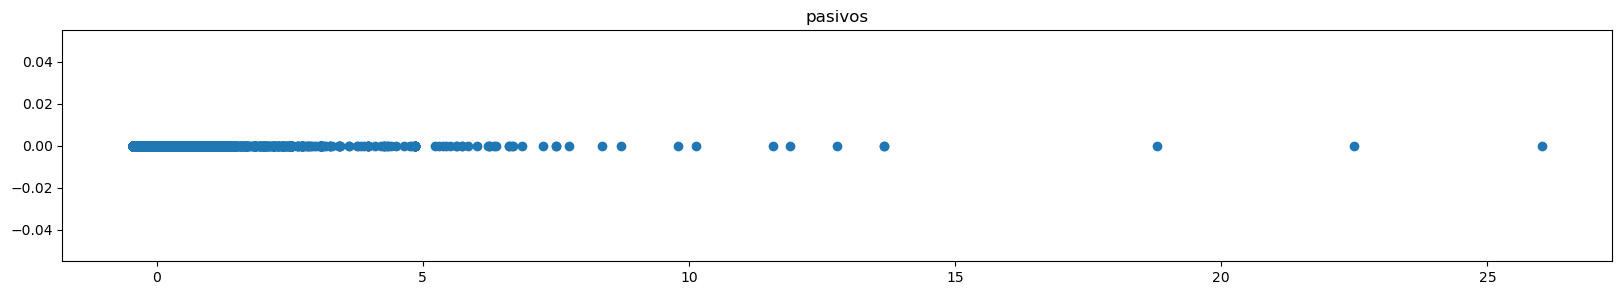

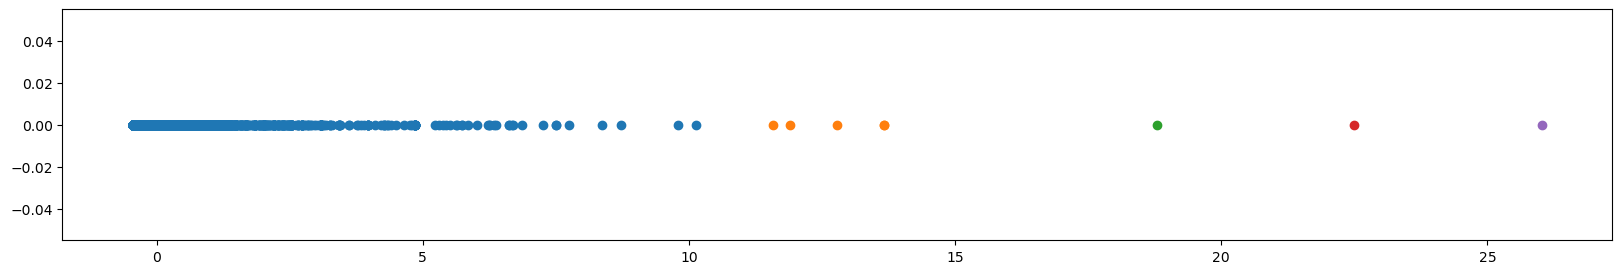

[Categoricer 2023-05-27 18:00:30.933842] Column: pasivos, creating categories labels
[Categoricer 2023-05-27 18:00:31.140004] Column: vol_trans, is Numeric
[Categoricer 2023-05-27 18:00:35.804447] Column: vol_trans, optimal K: 8


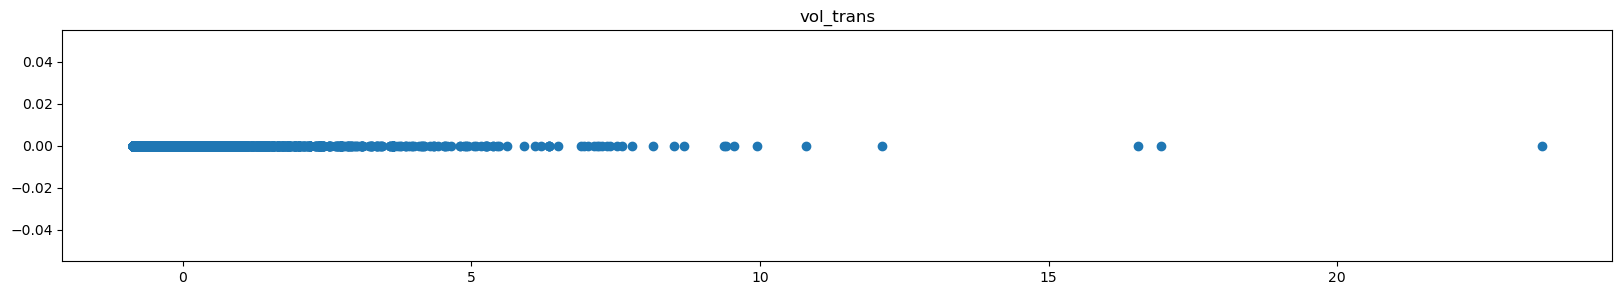

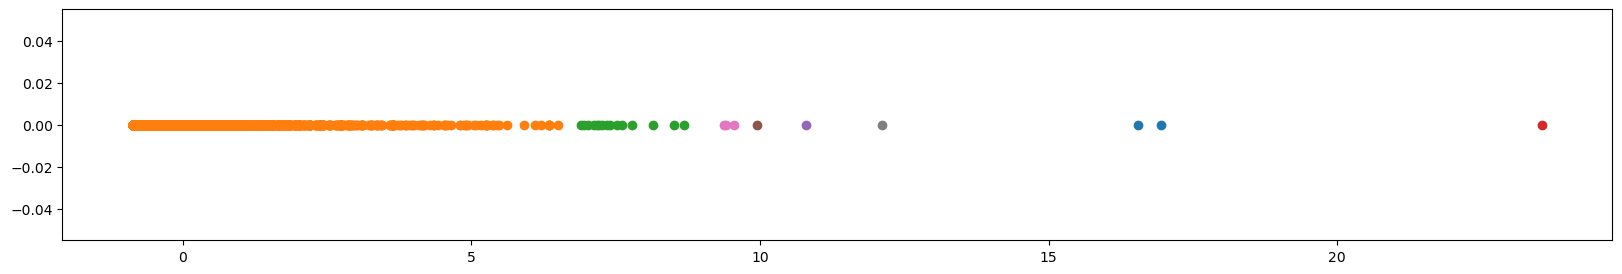

[Categoricer 2023-05-27 18:00:36.241427] Column: vol_trans, creating categories labels
[Categoricer 2023-05-27 18:00:36.442324] Column: a_econ, is Categorical
[Categoricer 2023-05-27 18:00:36.442404] Column: a_econ, creating categories labels
[Categoricer 2023-05-27 18:00:36.448860] Column: edad, is Numeric
[Categoricer 2023-05-27 18:00:40.964551] Column: edad, optimal K: 4


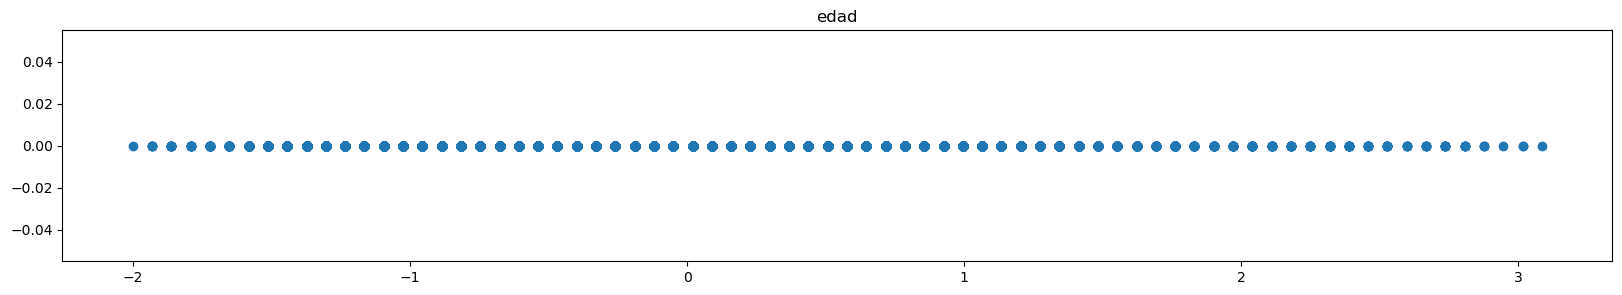

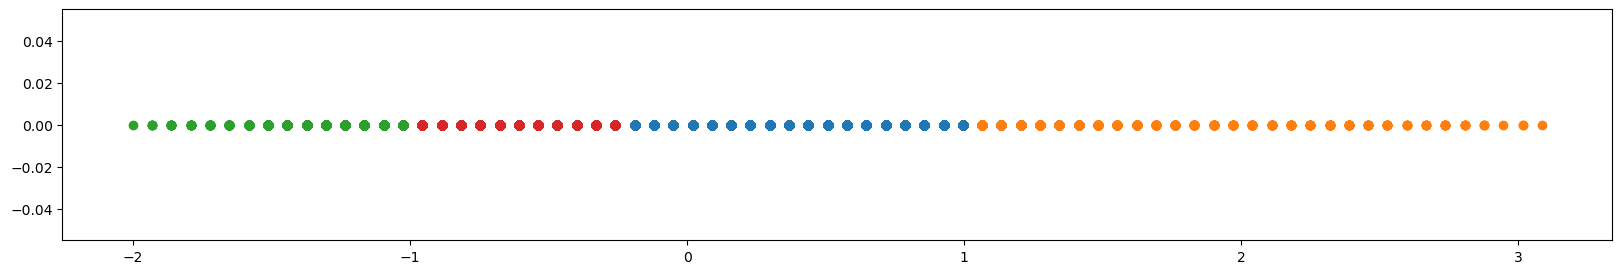

[Categoricer 2023-05-27 18:00:41.387092] Column: edad, creating categories labels
[Categoricer 2023-05-27 18:00:41.587037] Column: anos_afil, is Numeric
[Categoricer 2023-05-27 18:00:46.145164] Column: anos_afil, optimal K: 9


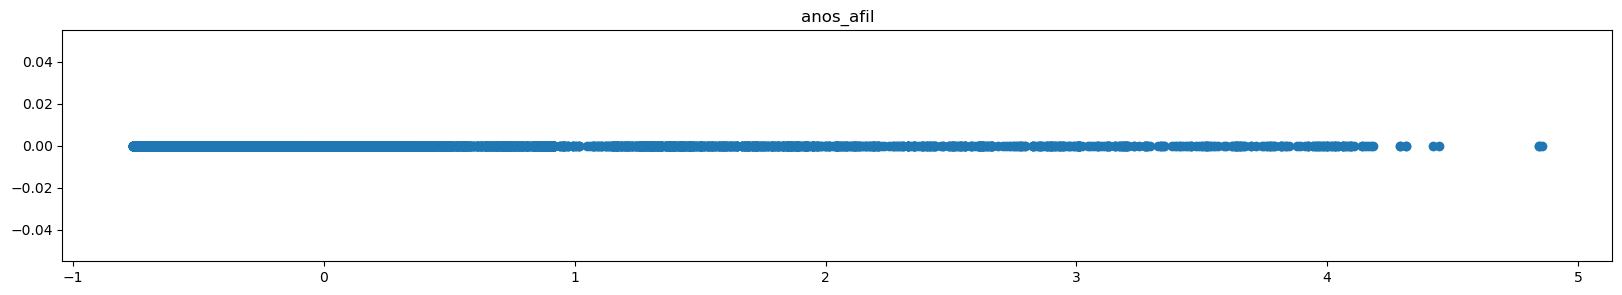

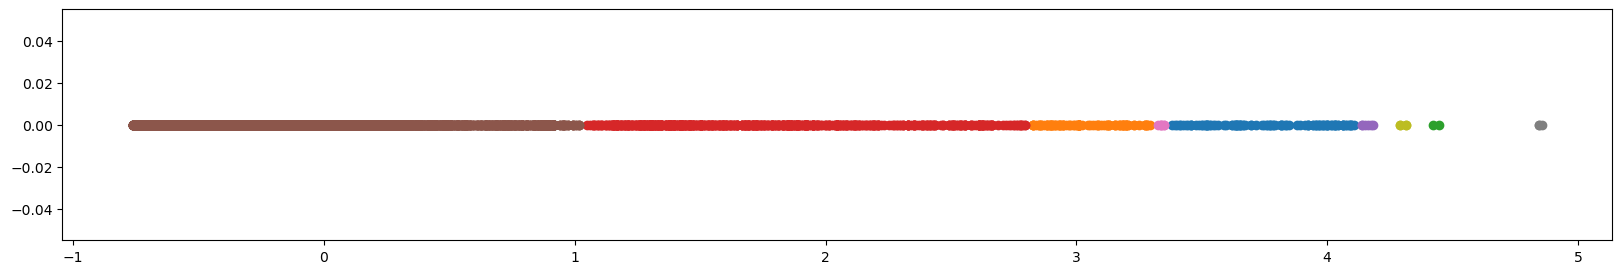

[Categoricer 2023-05-27 18:00:46.594912] Column: anos_afil, creating categories labels
[Categoricer 2023-05-27 18:00:46.798465] Column: genero, is Categorical
[Categoricer 2023-05-27 18:00:46.798520] Column: genero, creating categories labels
[Categoricer 2023-05-27 18:00:46.800670] Column: estado_civil, is Categorical
[Categoricer 2023-05-27 18:00:46.800683] Column: estado_civil, creating categories labels
[Categoricer 2023-05-27 18:00:46.803927] Column: ocupacion, is Categorical
[Categoricer 2023-05-27 18:00:46.803935] Column: ocupacion, creating categories labels
[Categoricer 2023-05-27 18:00:46.807001] Column: nivel_estudio, is Categorical
[Categoricer 2023-05-27 18:00:46.807008] Column: nivel_estudio, creating categories labels
[Categoricer 2023-05-27 18:00:46.810992] Column: tipo_vivienda, is Categorical
[Categoricer 2023-05-27 18:00:46.811000] Column: tipo_vivienda, creating categories labels
[Categoricer 2023-05-27 18:00:46.813221] Column: estrato, is Categorical
[Categoricer 2

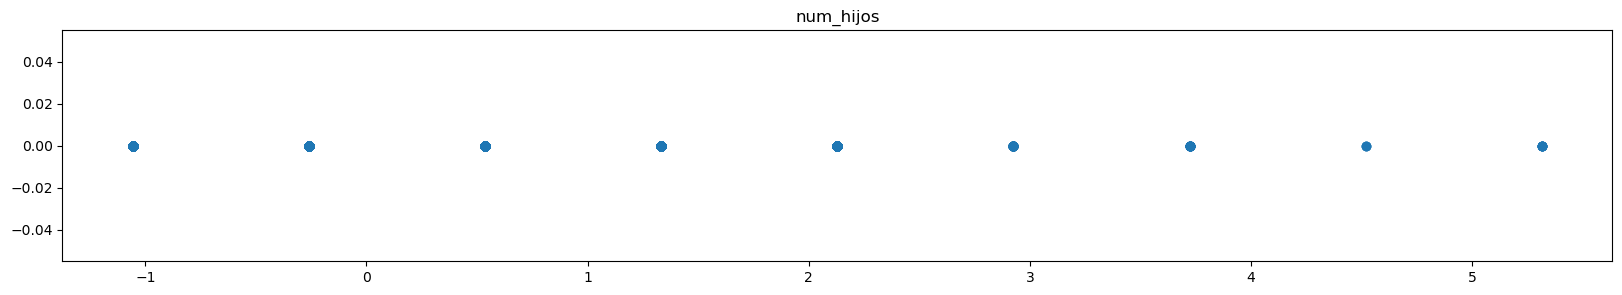

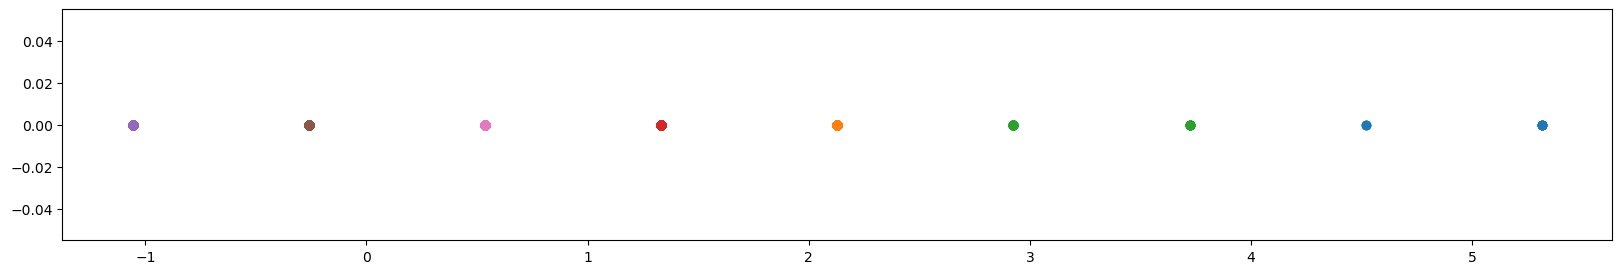

[Categoricer 2023-05-27 18:00:52.173997] Column: num_hijos, creating categories labels
[Categoricer 2023-05-27 18:00:52.375819] Column: personas_cargo, is Numeric
[Categoricer 2023-05-27 18:00:57.704936] Column: personas_cargo, optimal K: 4


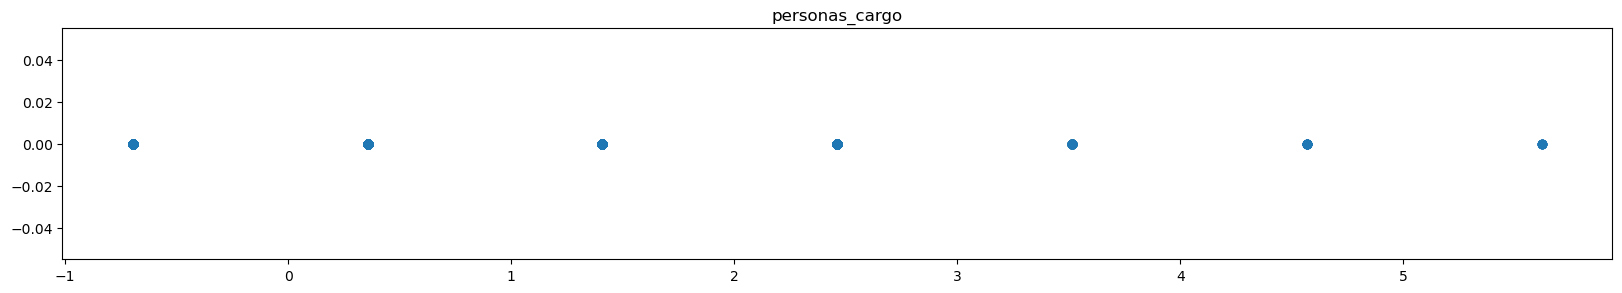

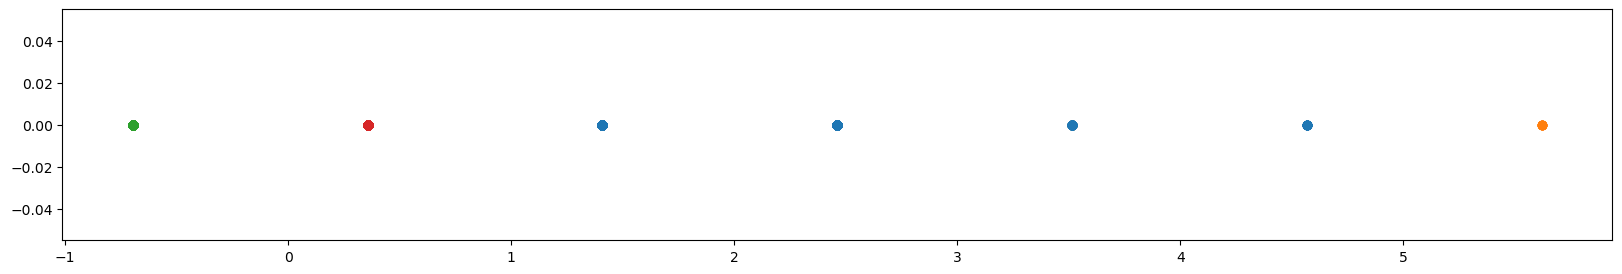

[Categoricer 2023-05-27 18:00:58.115860] Column: personas_cargo, creating categories labels
[Categoricer 2023-05-27 18:00:58.315630] Column: special_test_1, is Numeric
[Categoricer 2023-05-27 18:01:03.045899] Column: special_test_1, optimal K: 5


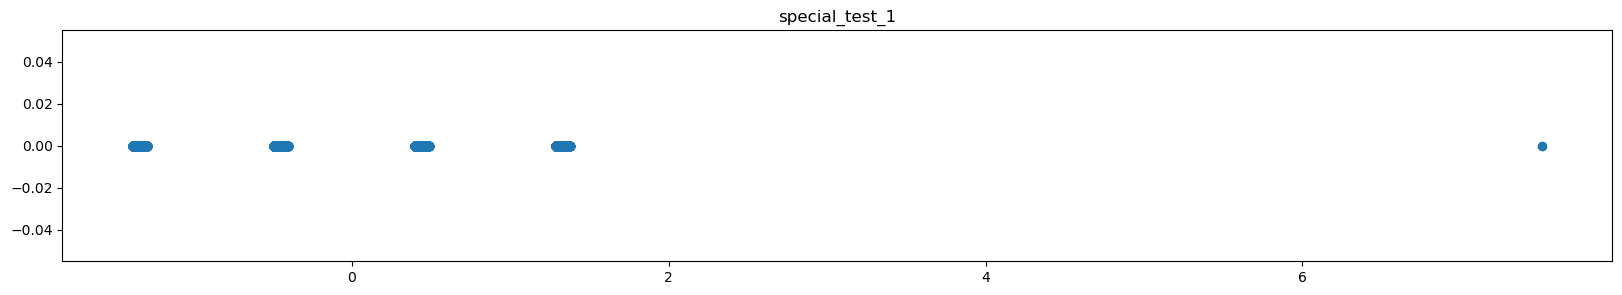

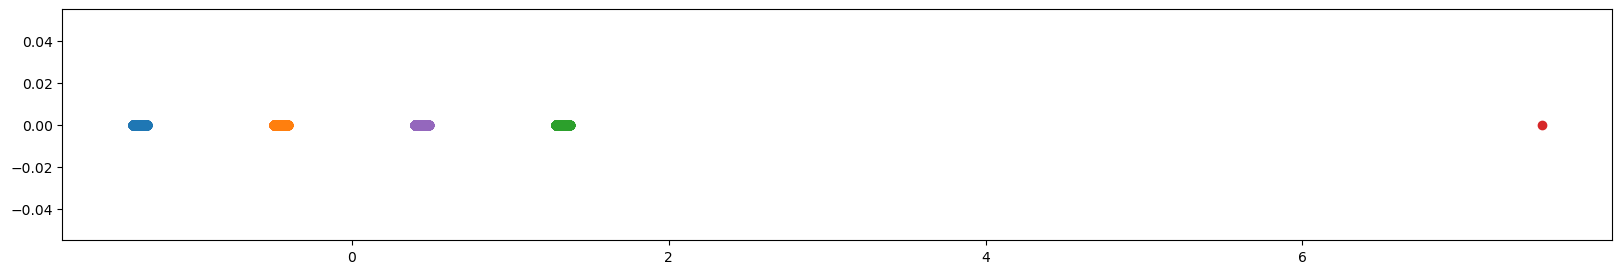

[Categoricer 2023-05-27 18:01:03.548210] Column: special_test_1, creating categories labels


OSError: Cannot save file into a non-existent directory: 'data'

In [4]:
categoricer = Categoricer(show_graph_solution=True)
#categories = categoricer.generate_cagegories(data.iloc[:, :6])
categories = categoricer.generate_cagegories(data)
categories.to_csv(r"./data/data_categories.csv")